In [17]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn


import pickle
import os
import time

In [18]:
if not os.path.exists('models'):
    os.makedirs('models')

if not os.path.exists('results'):
    os.makedirs('results')

if not os.path.exists('data'):
    os.makedirs('data')

In [19]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [20]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [21]:
import torch
import torch.nn as nn

class VGG8(nn.Module):
    def __init__(self, num_classes=10, init_weights=True):
        super(VGG8, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            # Block 1: 64 filters
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: 128 filters
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: 256 filters
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4: 512 filters
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Adaptive pooling to handle different input sizes
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # Fully connected classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

        # Initialize weights
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)



In [22]:
model = VGG8(num_classes=10)  # For CIFAR-10

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [24]:
model.to(device)

VGG8(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7)

In [26]:
train_loss = []
train_accuracy = []
epoch_time = []

for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        if i % 4000 == 3999:    # print every 4000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 4000))
            print('Time:', time.time() - start_time)
            running_loss = 0.0

    # Calculate epoch metrics
    end_time = time.time()
    epoch_time.append(end_time - start_time)

    # Calculate average loss for the epoch
    epoch_loss = 0.0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

    avg_loss = epoch_loss / len(trainloader)
    train_loss.append(avg_loss)

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total
    train_accuracy.append(accuracy)

    print(f'Epoch {epoch+1} completed. Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time[-1]:.2f}s')

print('Finished Training of VGG8 on CIFAR-10')

[1,  4000] loss: 2.059
Time: 220.21454572677612
[1,  8000] loss: 1.740
Time: 439.7981822490692
[1, 12000] loss: 1.575
Time: 659.4548156261444
Epoch 1 completed. Loss: 1.478, Accuracy: 34.88%, Time: 686.99s
[2,  4000] loss: 1.442
Time: 219.2517318725586
[2,  8000] loss: 1.368
Time: 438.70447063446045
[2, 12000] loss: 1.306
Time: 657.9601356983185
Epoch 2 completed. Loss: 1.195, Accuracy: 50.77%, Time: 685.47s
[3,  4000] loss: 1.174
Time: 219.44958209991455
[3,  8000] loss: 1.116
Time: 438.72759556770325
[3, 12000] loss: 1.063
Time: 657.9429981708527
Epoch 3 completed. Loss: 1.008, Accuracy: 60.36%, Time: 685.41s
[4,  4000] loss: 0.951
Time: 218.86345505714417
[4,  8000] loss: 0.932
Time: 438.04219245910645
[4, 12000] loss: 0.894
Time: 657.5327560901642
Epoch 4 completed. Loss: 0.832, Accuracy: 67.49%, Time: 685.07s
[5,  4000] loss: 0.767
Time: 219.0044059753418
[5,  8000] loss: 0.778
Time: 437.67950677871704
[5, 12000] loss: 0.770
Time: 656.7870860099792
Epoch 5 completed. Loss: 0.610, 

In [27]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network : %.2f %%' % (100 * correct / total))

Accuracy of the network : 70.10 %


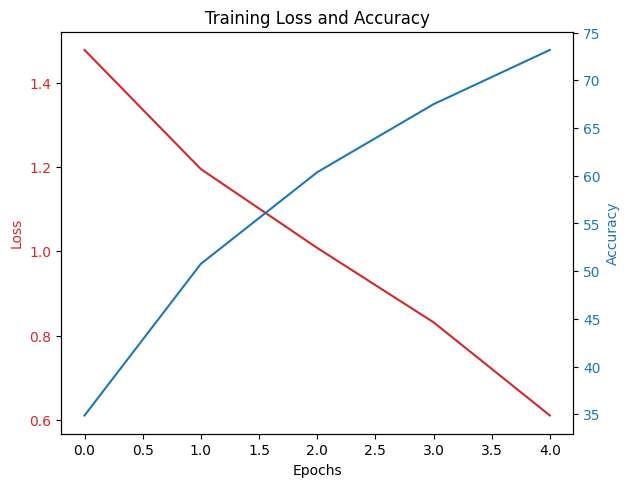

In [28]:
def plot_loss_accuracy(train_loss, train_accuracy):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(train_loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(train_accuracy, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Training Loss and Accuracy')
    plt.show()
plot_loss_accuracy(train_loss, train_accuracy)

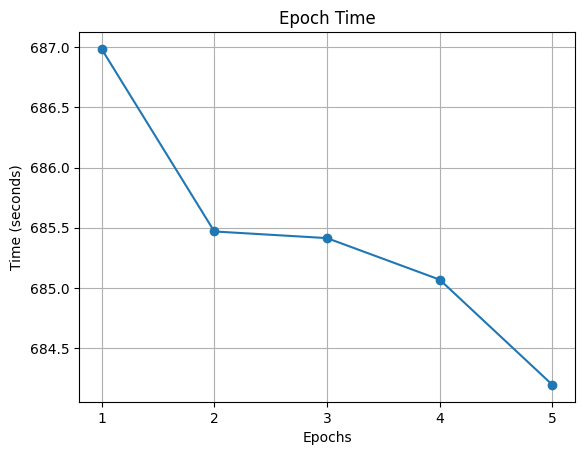

In [29]:
# plot the training time for each epoch where step size on the graph is 1 epoch
# and the y-axis is the time taken for each epoch in seconds
def plot_epoch_time(epoch_time):
    plt.plot(range(1, len(epoch_time) + 1), epoch_time, marker='o')
    plt.title('Epoch Time')
    plt.xlabel('Epochs')
    plt.ylabel('Time (seconds)')
    plt.xticks(range(1, len(epoch_time) + 1))
    plt.grid()
    plt.show()

plot_epoch_time(epoch_time)

In [30]:
#Save the training loss and accuracy and epoch time
with open(os.path.join('results', 'training_results_vgg8.pkl'), 'wb') as f:
    pickle.dump({'loss': train_loss, 'accuracy': train_accuracy, 'epoch_time': epoch_time}, f)

In [31]:
# Save the model architecture and weights
PATH = os.path.join(os.getcwd(),'models', 'vgg8_cifar10.pth')
torch.save(model.state_dict(), PATH)